In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

In [2]:
base_dist = tfd.Independent(tfd.Uniform(low= [0., 0.], high= [1., 1.]), reinterpreted_batch_ndims=1)
# target_dist = tfd.Independent(tfd.Normal(loc= [0., 0.], scale= [1., 1.]), reinterpreted_batch_ndims=1)
target_dist =tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag=[1., 1.])

#Make the neural netowrks that learn the shift and log scale functions
def shift_and_log_scale_nn(hidden_units, num_masked):
    model = keras.Sequential()
    for units in hidden_units:
        model.add(layers.Dense(units, activation="relu"))
    model.add(layers.Dense(num_masked * 2, activation=None))
    return model

#Make the RealNVP bijectors with the shift and log scale functions
def make_rnvp_bijector(num_masked, hidden_units):
    _shift_and_log_scale_nn = shift_and_log_scale_nn(hidden_units, num_masked)
    
    def _hift_and_log_scale_fn(x, output_units, **kwargs):
        params = _shift_and_log_scale_nn(x)
        shift, log_scale = tf.split(params, num_or_size_splits=2, axis=-1)
        return shift, log_scale
    
    bijector = tfb.RealNVP(
        num_masked=num_masked,
        shift_and_log_scale_fn=_hift_and_log_scale_fn
    )
    
    bijector.shift_and_log_scale_nn = _shift_and_log_scale_nn #Attatching net to bijector for training
    return bijector

#Combine the bijectors into a chain to get the final flow
num_flows = 20
bijectors = []
for i in range(num_flows):
    bijectors.append(make_rnvp_bijector(num_masked=1, hidden_units=[128, 128]))
    bijectors.append(tfb.Permute(permutation=[1, 0])) #Permute the dimensions after each RealNVP
#reverse the list of bijectors so that the flow goes in the right direction
flow_bijector = tfb.Chain(list(reversed(bijectors)))


In [3]:
#Make the normalizing flow model in keras as a custom model
class NormalizingFlow(keras.Model):
    def __init__(self, flow_bijector, base_dist, target_dist):
        super(NormalizingFlow, self).__init__() #Inherit from keras.Model
        self.flow_bijector = flow_bijector
        self.base_dist = base_dist
        self.target_dist = target_dist
        
        #Go through the bijectors and attach the shift and log scale nets to the model as a layer
        #This allows us to track the trainable variables in the model
        for i, bij in enumerate(self.flow_bijector.bijectors):
            if hasattr(bij, "shift_and_log_scale_nn"):
                setattr(self, f"shift_and_log_scale_nn_{i}", bij.shift_and_log_scale_nn)
    
    def call(self, x):
        return self.flow_bijector.forward(x)
    
    def compute_loss(self, x):
        z = self.flow_bijector.forward(x)
        log_det = self.flow_bijector.forward_log_det_jacobian(x, event_ndims=1)
        log_prob_target = self.target_dist.log_prob(z)
        return -tf.reduce_mean(log_prob_target + log_det )
    


In [4]:
nf_model = NormalizingFlow(flow_bijector, base_dist, target_dist)

#Train the model
optimizer = keras.optimizers.Adam(1e-3)
batch_size = 128
epochs = 1_000

for i in range(epochs):
    base_batch = base_dist.sample(batch_size)
    with tf.GradientTape() as tape:
        loss = nf_model.compute_loss(base_batch)
    gradients = tape.gradient(loss, nf_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, nf_model.trainable_variables))
    
    if i % 100 == 0:
        print(f"Step: {i}, Loss: {loss.numpy()}")

Step: 0, Loss: 2.2059102058410645
Step: 100, Loss: 0.20305532217025757
Step: 200, Loss: 0.18942877650260925
Step: 300, Loss: 0.19590337574481964
Step: 400, Loss: 0.14990189671516418
Step: 500, Loss: 0.03530272841453552
Step: 600, Loss: 0.16797474026679993
Step: 700, Loss: 0.14900359511375427
Step: 800, Loss: 0.1150512844324112
Step: 900, Loss: 0.0788346379995346


(-3.5352365374565125,
 3.802914083003998,
 -3.645624506473541,
 3.3894144177436827)

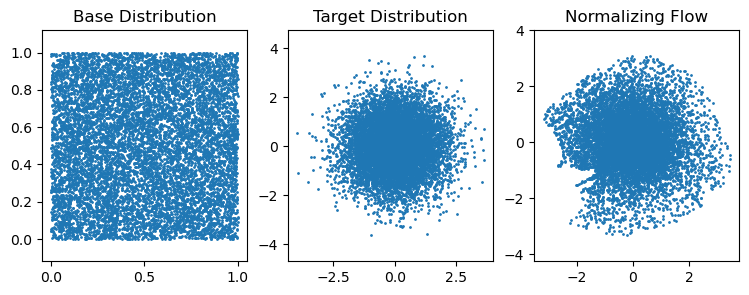

In [5]:
n_samples = 10_000

uniform_samples = (base_dist.sample(n_samples)).numpy()
target_samples = (target_dist.sample(n_samples)).numpy()
nf_samples = nf_model.flow_bijector.forward(uniform_samples).numpy()

plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.scatter(uniform_samples[:, 0], uniform_samples[:, 1], s=1)
plt.title("Base Distribution")
plt.axis("equal")

plt.subplot(1, 3, 2)
plt.scatter(target_samples[:, 0], target_samples[:, 1], s=1)
plt.title("Target Distribution")
plt.axis("equal")

plt.subplot(1, 3, 3)
plt.scatter(nf_samples[:, 0], nf_samples[:, 1], s=1)
plt.title("Normalizing Flow")
plt.axis("equal")

In [6]:
#Doing the Kolmogorov-Smirnov test to see how well the normalizing flow matches the target distribution

from scipy.stats import kstest, chi2

r_squared = np.sum(nf_samples**2, axis=1)

D, p_value = kstest(r_squared, 'chi2', args=(2,))
print(f"KS-Test: D = {D}, p-value = {p_value}")

KS-Test: D = 0.04170303965016897, p-value = 1.5046412170217003e-15
